# NOTE

It would be really cool to introduce some time-dependency or history information for the model.
- either introduce some change information into clustering features, e.g. 1 year change, 5 year change, ... 
    - this would help bring together areas that have changes in a similar way during last years
- another time-related implementation would be to predict cluster changes --> how is the area going to change in the future? 
    - maybe for this you can do a multi-output time-series model, a.k.a all features as training, all features forecasted into the future. From there you could predict the new cluster for the forecasted feature values.
    - That is, you get a sufficiently working cluster analysis where you can identify what each cluster means.
    - problem could be data, as i dont think we have enough data... but will see!


- actually if you want you could just introduce all areas into the clustering dataset --> instead of considering e.g. `00100` you consider `00100 in 2021, 2020, ...`. --> includes number of data to cluster


## GenAI Application

Area description
- give area, data of area, form area description based on that --> works as a certain type of report

Semantic search? 
- a.k.a a user gives input text of what kind of an area they are looking for, code searches for the area that matches the description. 
- problem --> how on earth would this work? How can you match embedded information to the actual data itself, and hence to the cluster?? Interesting problem. 

Visualizations
- make model to visualize the area for you based on the description, give 2-3 images that represent the area. 
- i think this will be super challenging because we would need information about e.g. countryside, nature, forest, architecture, etc. but idk, we will see!

---
# Combined data

Here we collect all the individually explored and cleaned up data, and do final exploration and processing before passing it for modeling. This is discussion based, and maybe later we can convert these notebooks into a single script that can be more easily run through to get the processed data.

### Setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport

from utils import normalize_by_population

%matplotlib inline
sns.set_theme()

id_cols = ["postcode", "name", "municipality"]

### Data load

aka loop through all the data that you have cleaned up and saved + collect it into one dataset.

In [114]:
ROOT = Path(".").absolute().parent
DATA = ROOT / "data"

df = pd.concat([pd.read_csv(f) for f in DATA.glob("*_clean*")], axis=1)
df = df.loc[:, ~df.columns.duplicated()]  # drop duplicated columns
df

,postcode,name,municipality,avg_income,median_income,low_income,med_income,high_income,average_size_of_households,average_floor_area_per_person,...,middle_age,elders,primary_production,processing,services,workforce_to_workplaces,unemployment,basic_education,high_school,university
0,100,Helsinki keskusta - Etu-T��l�,Helsinki,45302.0,31186.0,0.174658,0.409827,0.415515,1.7,39.7,...,0.236661,0.183638,0.000451,0.044419,0.955130,0.191484,0.059384,0.115897,0.272114,0.611990
1,120,Punavuori - Bulevardi,Helsinki,56441.0,32491.0,0.160412,0.393622,0.445966,1.8,40.1,...,0.233037,0.174499,0.000371,0.025828,0.973801,0.527929,0.059457,0.113545,0.286036,0.600419
2,130,Kaartinkaupunki,Helsinki,77808.0,35684.0,0.185310,0.320755,0.493935,1.9,44.2,...,0.277296,0.176199,0.001008,0.028518,0.970402,0.070935,0.047716,0.129380,0.276280,0.594340
3,140,Kaivopuisto - Ullanlinna,Helsinki,77060.0,33228.0,0.166317,0.378334,0.455349,1.8,42.5,...,0.251779,0.204554,0.002915,0.055029,0.941691,1.568149,0.063909,0.112976,0.266107,0.620917
4,150,Punavuori - Eira - Hernesaari,Helsinki,48755.0,30608.0,0.162950,0.443029,0.394021,1.6,35.4,...,0.234441,0.169174,0.000884,0.164050,0.835065,1.246297,0.072202,0.122887,0.293310,0.583803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815,99910,Kaamanen-Partakko,Inari,20842.0,17696.0,0.406015,0.481203,0.112782,1.6,50.2,...,0.260563,0.457746,0.030303,0.090909,0.878788,1.575758,0.153846,0.263158,0.511278,0.225564
2816,99930,Sevettij�rvi-N��t�m�,Inari,23156.0,20442.0,0.312821,0.523077,0.164103,1.9,48.9,...,0.363208,0.339623,NaN,NaN,NaN,12.333333,0.126126,0.210256,0.589744,0.200000
2817,99950,Karigasniemi,Utsjoki,25104.0,22495.0,0.234043,0.595745,0.170213,1.9,49.7,...,0.292517,0.255102,0.058824,0.029412,0.911765,1.911765,0.115385,0.272340,0.485106,0.242553
2818,99980,Utsjoki Keskus,Utsjoki,25238.0,22125.0,0.228070,0.617544,0.154386,1.9,45.9,...,0.242879,0.353823,0.041494,0.062241,0.896266,1.203320,0.079310,0.264912,0.422807,0.312281


So with manual clean up we have reduced number of columns from 86 to 33. Lets also load coordinates for each postal code area - I might use it in later modeling.

In [115]:
data_orig = pd.read_csv(DATA / "paavo_preclean.csv", usecols=["postcode", "name", "municipality", "X coordinate","Y coordinate"])
data_orig.head()

,postcode,name,municipality,X coordinate,Y coordinate
0,100,Helsinki keskusta - Etu-T��l�,Helsinki,384979,6672361
1,120,Punavuori - Bulevardi,Helsinki,385531,6671434
2,130,Kaartinkaupunki,Helsinki,386244,6671474
3,140,Kaivopuisto - Ullanlinna,Helsinki,386394,6670766
4,150,Punavuori - Eira - Hernesaari,Helsinki,385320,6670373


In [116]:
df = df.join(data_orig.set_index(id_cols), on=id_cols, how="left")
df.head()

,postcode,name,municipality,avg_income,median_income,low_income,med_income,high_income,average_size_of_households,average_floor_area_per_person,...,primary_production,processing,services,workforce_to_workplaces,unemployment,basic_education,high_school,university,X coordinate,Y coordinate
0,100,Helsinki keskusta - Etu-T��l�,Helsinki,45302.0,31186.0,0.174658,0.409827,0.415515,1.7,39.7,...,0.000451,0.044419,0.955130,0.191484,0.059384,0.115897,0.272114,0.611990,384979,6672361
1,120,Punavuori - Bulevardi,Helsinki,56441.0,32491.0,0.160412,0.393622,0.445966,1.8,40.1,...,0.000371,0.025828,0.973801,0.527929,0.059457,0.113545,0.286036,0.600419,385531,6671434
2,130,Kaartinkaupunki,Helsinki,77808.0,35684.0,0.185310,0.320755,0.493935,1.9,44.2,...,0.001008,0.028518,0.970402,0.070935,0.047716,0.129380,0.276280,0.594340,386244,6671474
3,140,Kaivopuisto - Ullanlinna,Helsinki,77060.0,33228.0,0.166317,0.378334,0.455349,1.8,42.5,...,0.002915,0.055029,0.941691,1.568149,0.063909,0.112976,0.266107,0.620917,386394,6670766
4,150,Punavuori - Eira - Hernesaari,Helsinki,48755.0,30608.0,0.162950,0.443029,0.394021,1.6,35.4,...,0.000884,0.164050,0.835065,1.246297,0.072202,0.122887,0.293310,0.583803,385320,6670373


Lets do a final profile report of all of the features together

In [117]:
skip = False
skip = True
if not skip: # we dont have to run it every time
    profile = ProfileReport(
        df.set_index(id_cols),
        title="Profile report of entire dataset",
        correlations={
            "pearson": {"calculate": False},
            "spearman": {"calculate": True},
            "kendall": {"calculate": False},
            "phi_k": {"calculate": False},
            "cramers": {"calculate": False},
        }
    )
    profile.to_file("profile_reports/paavo_cleaned.html")

## Observations

- Income and education is highly correlated with each other

We see that high university-educated proportions are associated with high average income. Conversely low income is associated with low income. This makes sense since usually in the labor market highly educated people tend to be awarded with higher paying positions.

- Number of pensioners and elders seems to be associated with low income, higher living area per person, and lower education.

- Primary production is very negatively associated with total number of inhabitants and apartments proportions.

This in a way represents the trend of allocating industrial areas, or areas where there is a lot of primary production, but little residents.
    

---

# TODO: 

- However, from the exploration I already knew that there is a lot of collinearity between features. 
    - therefore for modeling it would be better to drop --> helps modeling if we dont have cross-related features
    - ALSO the more the features there are, tho worse k-means clustering will work (TODO: Add discussion, show and tell why, and what you can do in that case). You should also maybe add discussion on what kind of other clustering methods you could use, what works best.
-  Final processing of the data so that the data satisfies requirements for PCA/modeling.
    - e.g normalization, etc.
    - btw recap: when to normalize and when to standardize

- save data for modeling. Have modeling on different noteboooks


---

## Dimension reduction

However, as seen in the report, there is still a lot of variables, 33. This is a slight problem, since it is possible that clustering tasks will not work so will with sparse and multi-dimensional data (see [this](https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions/) forum discussion about Euclidean distance). Therefore, it would still be a better idea to reduce the number of dimensions. I could do this by two methods
1. Final manual inspection of variables
2. PCA 



### 1. Manual dropping of variables

Upon looking at the report, I saw that there were still some variables that were in some way duplicated. These are listed below and I describe what strategy I will have for them

- `Median` and `mean income` describe the same thing --> Use only median. Is more robust for non-normal distributions
- `Owner-occupied` and `rented` describe same thing but opposite; if not owner-occupied, then the house is probably rented. --> use only owner-occupied
- `females` and `males` describe same thing but opposite --> use only proprtion of females
- Also elders are almost exclusively pensioners --> don't need both variables --> use only elders

In [118]:
drop_cols = ["avg_income", "rented", "pensioner_households", "males"]
df.drop(columns=drop_cols, inplace=True)
df.head()

,postcode,name,municipality,median_income,low_income,med_income,high_income,average_size_of_households,average_floor_area_per_person,one_person_households,...,primary_production,processing,services,workforce_to_workplaces,unemployment,basic_education,high_school,university,X coordinate,Y coordinate
0,100,Helsinki keskusta - Etu-T��l�,Helsinki,31186.0,0.174658,0.409827,0.415515,1.7,39.7,0.529864,...,0.000451,0.044419,0.955130,0.191484,0.059384,0.115897,0.272114,0.611990,384979,6672361
1,120,Punavuori - Bulevardi,Helsinki,32491.0,0.160412,0.393622,0.445966,1.8,40.1,0.512279,...,0.000371,0.025828,0.973801,0.527929,0.059457,0.113545,0.286036,0.600419,385531,6671434
2,130,Kaartinkaupunki,Helsinki,35684.0,0.185310,0.320755,0.493935,1.9,44.2,0.449838,...,0.001008,0.028518,0.970402,0.070935,0.047716,0.129380,0.276280,0.594340,386244,6671474
3,140,Kaivopuisto - Ullanlinna,Helsinki,33228.0,0.166317,0.378334,0.455349,1.8,42.5,0.520346,...,0.002915,0.055029,0.941691,1.568149,0.063909,0.112976,0.266107,0.620917,386394,6670766
4,150,Punavuori - Eira - Hernesaari,Helsinki,30608.0,0.162950,0.443029,0.394021,1.6,35.4,0.605881,...,0.000884,0.164050,0.835065,1.246297,0.072202,0.122887,0.293310,0.583803,385320,6670373


The final number of variables is 30 (of which 3 are ID columns)

#### 2. PCA without coordinates

We will first do PCA without coordinates to see if there is any possibility of gaining any general non-location related insight of our data. This is also since the primary goal would be able to model areas without location information --> we want the model to search for similar areas in all of Finland, not just similar areas close to each other.

Lets operate through the same motions as in `population.ipynb`. 

**Nulls**

There was only some little missing nulls in the labor/production sector (see profile report). Lets do median imputing for them, as we do not want to drop those rows

In [119]:
impute_cols = ["primary_production", "processing", "services", "workforce_to_workplaces"]
imputer = SimpleImputer(strategy='median')
df[impute_cols] = imputer.fit_transform(df[impute_cols])

**Scaling**

In [141]:
df_for_pca = df.drop(columns=id_cols + ["X coordinate", "Y coordinate"])
scaler = StandardScaler()
scaled = scaler.fit_transform(df_for_pca)
df_scaled = pd.DataFrame(scaled, columns=df_for_pca.columns)
df_scaled

,median_income,low_income,med_income,high_income,average_size_of_households,average_floor_area_per_person,one_person_households,with_children,owner_occupied,small_houses_ratio,...,middle_age,elders,primary_production,processing,services,workforce_to_workplaces,unemployment,basic_education,high_school,university
0,2.257232,-0.771996,-2.980714,3.161537,-1.211858,-1.251958,1.273182,-0.830594,-1.965938,-3.153680,...,-0.921474,-1.092754,-0.844634,-1.120633,1.614209,-0.868222,-0.730083,-1.875503,-2.914060,3.240210
1,2.633724,-0.979878,-3.243591,3.568347,-0.881224,-1.189256,1.111289,-0.523945,-1.724680,-3.149111,...,-0.993253,-1.187638,-0.844968,-1.219801,1.685355,-0.774437,-0.728645,-1.910059,-2.722452,3.129740
2,3.554901,-0.616549,-4.425669,4.209219,-0.550589,-0.546565,0.536436,-0.290795,-1.857422,-3.154609,...,-0.116725,-1.169995,-0.842323,-1.205453,1.672401,-0.901825,-0.958667,-1.677394,-2.856716,3.071702
3,2.846347,-0.893711,-3.491603,3.693711,-0.881224,-0.813047,1.185553,-0.558424,-1.682949,-3.148228,...,-0.622076,-0.875598,-0.834408,-1.064038,1.563003,-0.484473,-0.641426,-1.918421,-2.996718,3.325439
4,2.090480,-0.942842,-2.442104,2.874375,-1.542493,-1.925999,1.973028,-0.901559,-1.829365,-3.138801,...,-0.965443,-1.242927,-0.842837,-0.482501,1.156720,-0.574190,-0.478964,-1.772803,-2.622346,2.971108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815,-1.634620,2.604177,-1.822828,-0.882950,-1.542493,0.393958,1.474436,-1.525284,-1.229143,0.214388,...,-0.448109,1.753132,-0.720754,-0.872648,1.323319,-0.482352,1.120542,0.288189,0.377340,-0.449028
2816,-0.842402,1.244199,-1.143537,-0.197312,-0.550589,0.190178,0.675214,-1.510565,0.731166,0.458584,...,1.584678,0.526729,-0.428352,-0.204472,0.113903,2.516352,0.577477,-0.489087,1.457186,-0.693089
2817,-0.250113,0.094601,0.035302,-0.115680,-0.550589,0.315581,0.936869,-0.174523,-0.851458,0.505320,...,0.184708,-0.350793,-0.602399,-1.200685,1.448973,-0.388689,0.367039,0.423107,0.017162,-0.286830
2818,-0.356858,0.007446,0.388935,-0.327125,-0.550589,-0.280084,1.209885,-0.651345,-1.159459,0.315726,...,-0.798343,0.674163,-0.674314,-1.025570,1.389915,-0.586170,-0.339695,0.313966,-0.840206,0.378864


In [142]:
pca = PCA(n_components=8)
df_pca = pca.fit_transform(df_scaled)
comps = 5
print(f"Variance explained by first {comps} components: {100 * sum(pca.explained_variance_ratio_[:comps]) :.2f}%")
pca.explained_variance_ratio_

Variance explained by first 5 components: 77.17%


array([0.36539496, 0.21950628, 0.08295785, 0.05493728, 0.04890633,
       0.04188943, 0.03603242, 0.02864253])

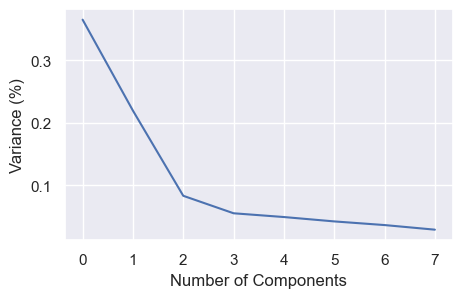

In [145]:
plt.figure(figsize=(5,3))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Number of Components")
plt.ylabel("Variance (%)")
plt.show()

So the first four components explain approximately 70% of the variance.

In [146]:
# Create a DataFrame for the loadings
loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, index=df_for_pca.columns, columns=[f"PC{i}" for i in range(1,9)])
loadings_scaled = loadings_df * 15

loadings_to_plot = loadings_scaled.loc[["median_income", "total_inhabitants"]]
loadings_to_plot = loadings_scaled.copy()

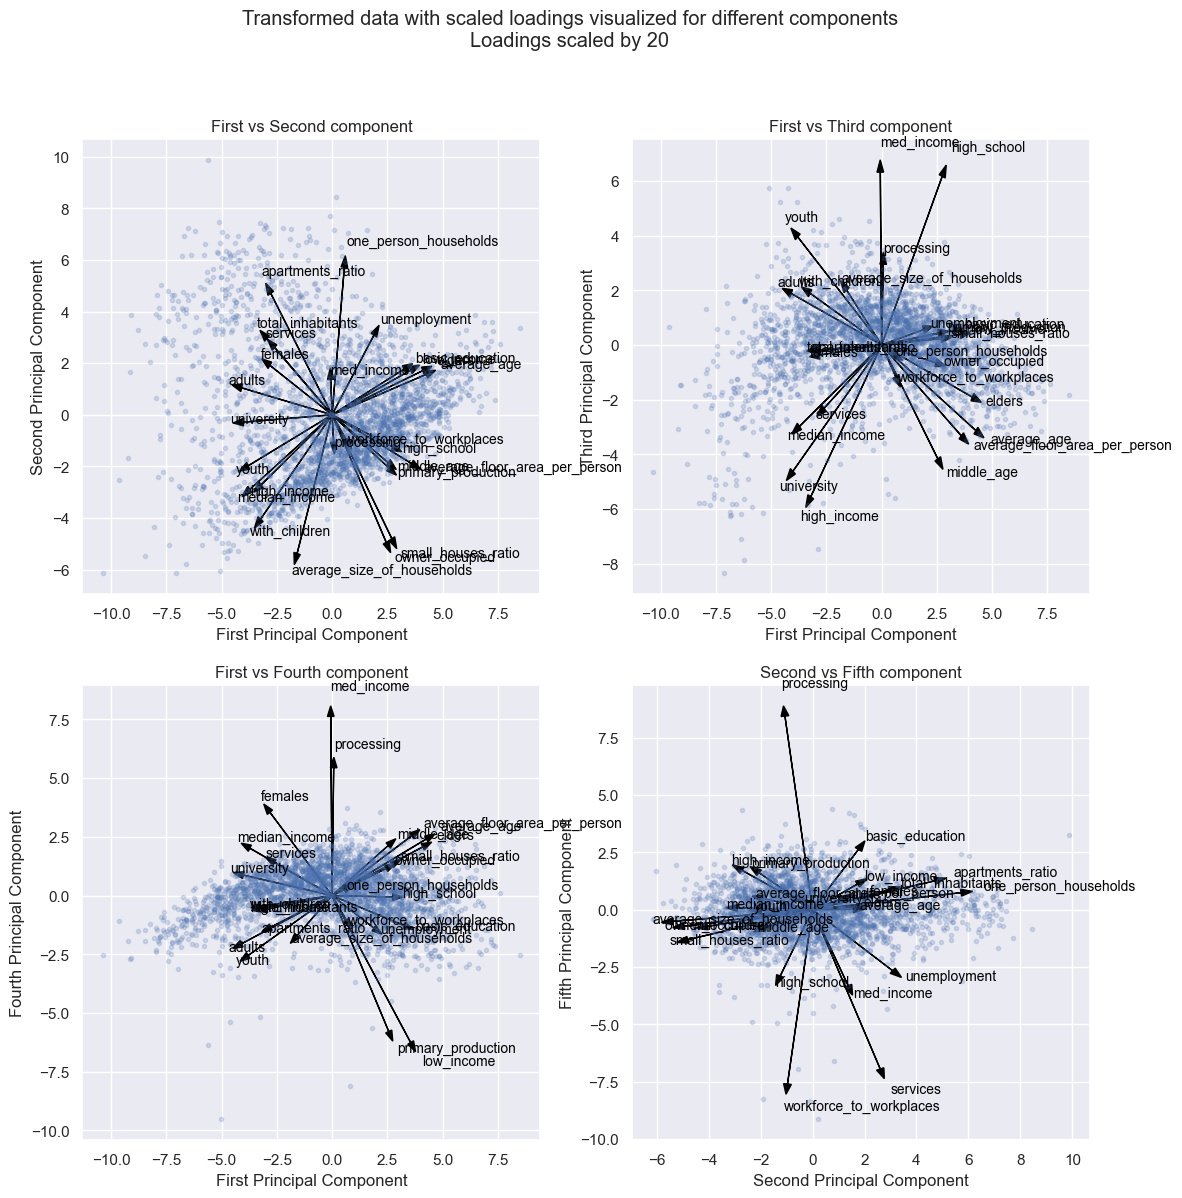

In [147]:
fig, axs = plt.subplots(2,2, figsize=(13,13))
plt.suptitle("Transformed data with scaled loadings visualized for different components\nLoadings scaled by 20")

pc1s = [0,0,0,1]
pc2s = [1,2,3,4]
pc_name_dict = dict(zip(range(5), ["First", "Second", "Third", "Fourth", "Fifth"]))

for i, (pc_name1, pc_name2) in enumerate(zip(pc1s, pc2s)):
    x = i // 2
    y = i % 2
    axs[x,y].plot(df_pca[:, pc_name1], df_pca[:, pc_name2], '.', alpha=0.2)
    for i, (pc1, pc2) in enumerate(zip(loadings_to_plot[f'PC{pc_name1+1}'], loadings_to_plot[f'PC{pc_name2+1}'])):
        axs[x,y].arrow(0, 0, pc1, pc2, color='black', alpha=1, head_width=0.3)
        axs[x,y].text(pc1 * 1.15, pc2 * 1.15, loadings_to_plot.index[i], color='black', fontsize=10)

    axs[x,y].set_xlabel(f"{pc_name_dict[pc_name1]} Principal Component")
    axs[x,y].set_ylabel(f"{pc_name_dict[pc_name2]} Principal Component")
    axs[x,y].set_title(f"{pc_name_dict[pc_name1]} vs {pc_name_dict[pc_name2]} component")
# plt.tight_layout()

### First component

The results on these two components are a bit tricky to interpret based on this image, as on one end there are tightly associated clusters, while on the other end there are several features that are quite widely distributed across the 2D space. Regarding the first component, it looks like the negative side is populated by young, high income, university education, low inhabitant counts, and low children counts. The other side is very difficult to interpret, lets print them out to see

In [148]:
loadings_df["PC1"].sort_values().head(5)
pd.DataFrame(loadings_df["PC1"].sort_values().tail(5))

,PC1
basic_education,0.216927
low_income,0.237123
average_floor_area_per_person,0.240508
elders,0.273775
average_age,0.284605


In [149]:
pd.DataFrame(loadings_df["PC1"].abs().sort_values().head(5))

,PC1
med_income,0.003913
processing,0.004854
one_person_households,0.037089
workforce_to_workplaces,0.042680
average_size_of_households,0.105488


So perhaps this component could be seen as a "age-education-hybrid", where low values describe a population of younger, highly educated working age individuals with higher median incomes. On the opposite end of the scale you would associate with elderly people, lower income, and lower levels of education. 

Factors that really made no contribution to the variance of this component was the proprtions of secondary sector, medium-level incomes, one-person households, and household sizes.

Another thing that is interesting that I found was `females` being scored quite highly on this component - what does this mean? Are women associated with lower age, higher average income, or higher education? Based on this visualization alone it is impossible to really draw inference, but perhaps it could be a symptom of women being more often University-educated when compared to men ([THL](https://thl.fi/aiheet/sukupuolten-tasa-arvo/tasa-arvon-tila/koulutus-ja-kasvatus/koulutuksen-sukupuolen-mukainen-segregaatio)).


### Second component

In [150]:
# top 5 loadings
pd.DataFrame(loadings_df["PC2"].sort_values().tail(5))

,PC2
services,0.173608
total_inhabitants,0.196949
unemployment,0.205542
apartments_ratio,0.313669
one_person_households,0.380989


In [151]:
# bottom 5 loadings
pd.DataFrame(loadings_df["PC2"].sort_values().head(5))

,PC2
average_size_of_households,-0.358029
owner_occupied,-0.329180
small_houses_ratio,-0.319756
with_children,-0.269301
median_income,-0.192604


One-person households, apartments are very clearly strongly associated with the second component, they are a lot higher than the rest. The other values are high unemployment, and inhabitant numbers, and services. On the other end there are smaller households sizes, lower levels of owner-occupation, small (separate) housing, and households with children --> **perhaps this could represent some level of urbanization?** Usually people living in big cities live alone in apartments in highly concentrated urban areas, where there are a lot of services available. During the cities there is also (due to pricing) less possibilities for owning a house, hence resulting in higher levels of renting. 

### Third and fourth component

The third component is even trickier to interpret. On the negative side there are some clear components, such as high income, university education, being middle-aged, and larger floor area per person. On the other end there is high school education, medium-size income, young workers, and proportions of processing in the area. Perhaps then, this component could represent the "blue vs white collar" feature of the population? Usually blue collar processing workers do not require a high education, and can get an industry-average salary, but salary growth is restricted, having a ceiling. Usually high income positions are reserved people in high-pressure enterprise positions, such as CEOs. Economic politics also have some effect on this, although that is a discussion for another day.

The fourth component is interesting, as it has a restricted amount of information that actually is impactful for this component. It seems that in this component, low income and the amount of primary production jobs are very highly connected to each other, and strongly negavtively associated with this component. On the other side, there is again median income and processing. I guess this in a way could represent the final dimension of the blue vs white collar discussion, where we have an area of low income primary sector work (farming, etc). We also notice that this is associated with lower levels of females in the area, suggesting that perhaps this line of work is statistically more associated with men. 

Lets finally check the loadings for the fifth component


In [152]:
pd.concat(
    [
        pd.DataFrame(loadings_df["PC5"].sort_values().head(5)),
        pd.DataFrame(loadings_df["PC5"].sort_values().tail(5)),
    ]
)

,PC5
workforce_to_workplaces,-0.507180
services,-0.463430
med_income,-0.221118
high_school,-0.192961
unemployment,-0.177647
apartments_ratio,0.083804
primary_production,0.107230
high_income,0.114184
basic_education,0.175109
processing,0.562895


This is clearly a more labor-structure representative feature - high amount of services is associated with high workforce-workplaces ratio, but not at all that much with processing. This could represent the nature of the work, as usually processing jobs require more hands to work, where as services are more easily maintained with less people. 

### Conclusion

We explored 5 components. None could really effectively capture all of the variance in the data, but with 5 components you reach ~80% coverage. This is not optimal moving forward, but considering the dimension challenges of various clustering algorithms, we should still try this. In addition, we more closely inspected the first five components, and retrieved some guesses for what they could represent.

The last factor that I noticed from a clustering point of view is that no real clusters were revealed from the data in the PCA plots. This might mean that modeling might be challenging, as we might not find any meaningful clusters.

Lets save this data for non-locational clustering. Lets also include verbal explanations of the first five components

In [158]:
pd.DataFrame(df_pca).to_csv(DATA / "pca_non_coords.csv", index=False)

explanations = { # TODO: Find out how to save this
    "1": {
        "low": "youth, higher income, uni education, more females",
        "high": "older people, lower income and education"
    },
    "2": {
        "low": "older people, lower income and education",
        "high": "larger owned houses, families, medium income",
    },
    "3": {
        "low": "white collar, high income and education, middle age",
        "high": "blue collar, younger people with lower education, processing, medium income",
    },
    "4": {
        "low": "lower income, primary production",
        "high": "median income, processing, more females",
    },
    "5": {
        "low": "services sector high, less workforce_workplaces ratio",
        "high": "processing sector high",
    },
}


---

### PCA with coordinates

Lets quickly check if the analysis changes when we include coordinates.

In [159]:
df_for_pca = df.drop(columns=id_cols)
scaler = StandardScaler()
scaled = scaler.fit_transform(df_for_pca)
df_scaled = pd.DataFrame(scaled, columns=df_for_pca.columns)
df_scaled.head()

,median_income,low_income,med_income,high_income,average_size_of_households,average_floor_area_per_person,one_person_households,with_children,owner_occupied,small_houses_ratio,...,primary_production,processing,services,workforce_to_workplaces,unemployment,basic_education,high_school,university,X coordinate,Y coordinate
0,2.257232,-0.771996,-2.980714,3.161537,-1.211858,-1.251958,1.273182,-0.830594,-1.965938,-3.153680,...,-0.844634,-1.120633,1.614209,-0.868222,-0.730083,-1.875503,-2.914060,3.240210,-0.180889,-1.164913
1,2.633724,-0.979878,-3.243591,3.568347,-0.881224,-1.189256,1.111289,-0.523945,-1.724680,-3.149111,...,-0.844968,-1.219801,1.685355,-0.774437,-0.728645,-1.910059,-2.722452,3.129740,-0.176306,-1.169402
2,3.554901,-0.616549,-4.425669,4.209219,-0.550589,-0.546565,0.536436,-0.290795,-1.857422,-3.154609,...,-0.842323,-1.205453,1.672401,-0.901825,-0.958667,-1.677394,-2.856716,3.071702,-0.170387,-1.169208
3,2.846347,-0.893711,-3.491603,3.693711,-0.881224,-0.813047,1.185553,-0.558424,-1.682949,-3.148228,...,-0.834408,-1.064038,1.563003,-0.484473,-0.641426,-1.918421,-2.996718,3.325439,-0.169142,-1.172636
4,2.090480,-0.942842,-2.442104,2.874375,-1.542493,-1.925999,1.973028,-0.901559,-1.829365,-3.138801,...,-0.842837,-0.482501,1.156720,-0.574190,-0.478964,-1.772803,-2.622346,2.971108,-0.178058,-1.174540


In [160]:
pca = PCA(n_components=8)
df_pca = pca.fit_transform(df_scaled)
comps = 5
print(f"Variance explained by first {comps} components: {100 * sum(pca.explained_variance_ratio_[:comps]) :.2f}%")
pca.explained_variance_ratio_

Variance explained by first 5 components: 73.97%


array([0.34564428, 0.20462627, 0.08247053, 0.05677752, 0.05013582,
       0.04081259, 0.0337525 , 0.03118202])

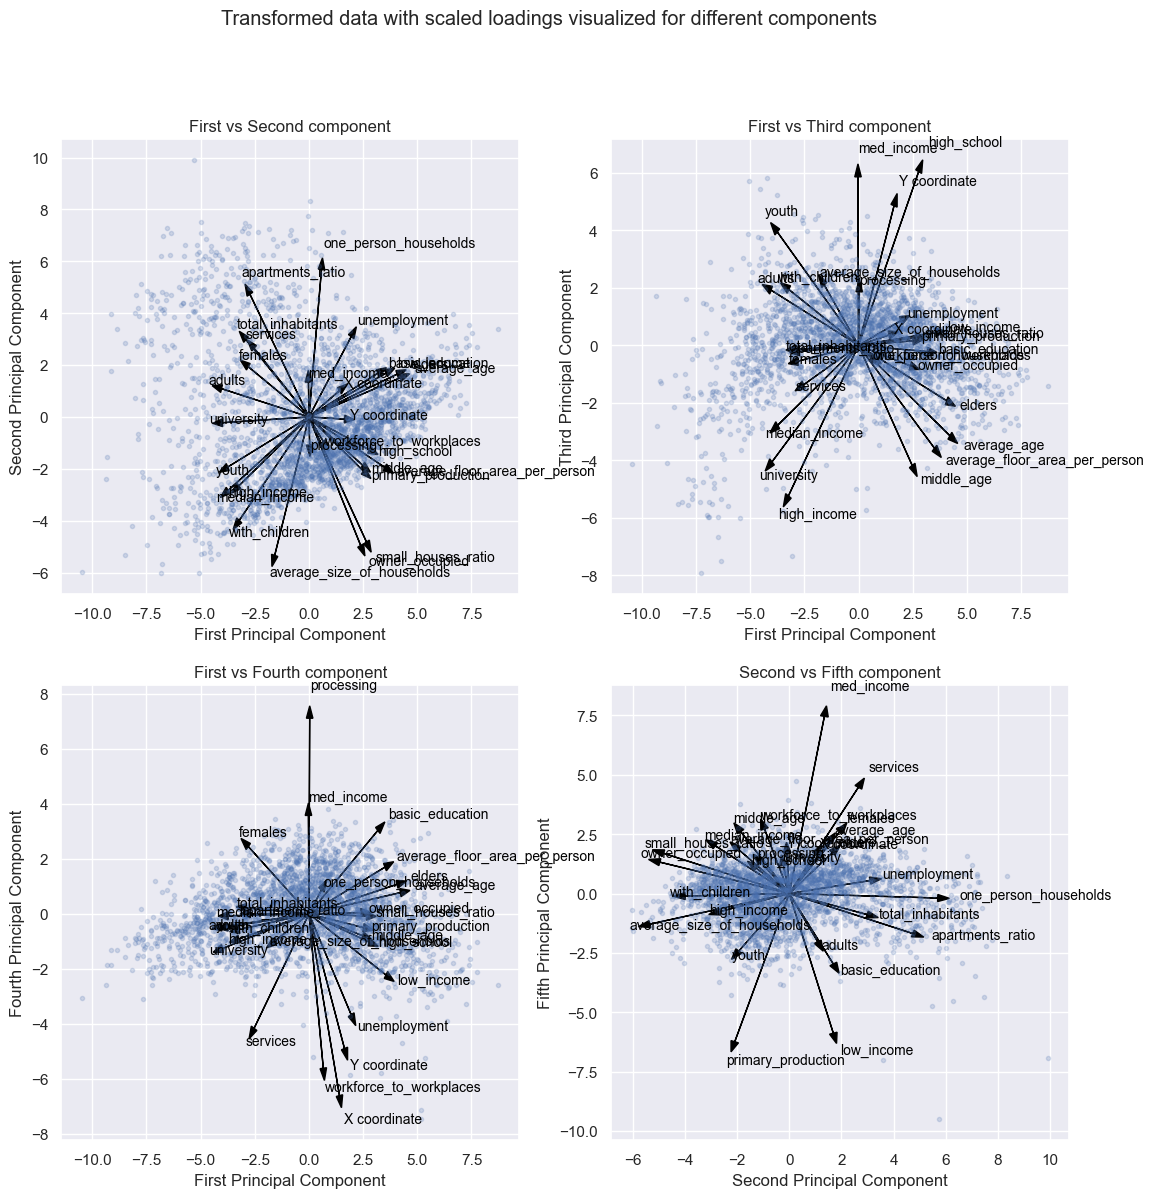

In [161]:
loadings = pca.components_.T
# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, index=df_for_pca.columns, columns=[f"PC{i}" for i in range(1,9)])
loadings_scaled = loadings_df * 15

loadings_to_plot = loadings_scaled.loc[["median_income", "total_inhabitants"]]
loadings_to_plot = loadings_scaled.copy()

fig, axs = plt.subplots(2,2, figsize=(13,13))
plt.suptitle("Transformed data with scaled loadings visualized for different components")


pc1s = [0,0,0,1]
pc2s = [1,2,3,4]
pc_name_dict = dict(zip(range(5), ["First", "Second", "Third", "Fourth", "Fifth"]))

for i, (pc_name1, pc_name2) in enumerate(zip(pc1s, pc2s)):
    x = i // 2
    y = i % 2
    axs[x,y].plot(df_pca[:, pc_name1], df_pca[:, pc_name2], '.', alpha=0.2)
    for i, (pc1, pc2) in enumerate(zip(loadings_to_plot[f'PC{pc_name1+1}'], loadings_to_plot[f'PC{pc_name2+1}'])):
        axs[x,y].arrow(0, 0, pc1, pc2, color='black', alpha=1, head_width=0.3)
        axs[x,y].text(pc1 * 1.15, pc2 * 1.15, loadings_to_plot.index[i], color='black', fontsize=10)

    axs[x,y].set_xlabel(f"{pc_name_dict[pc_name1]} Principal Component")
    axs[x,y].set_ylabel(f"{pc_name_dict[pc_name2]} Principal Component")
    axs[x,y].set_title(f"{pc_name_dict[pc_name1]} vs {pc_name_dict[pc_name2]} component")


Overall, the shapes of the PCA components do not change drastically. The point clouds of the PCA-transformations look approximately the same, and most of the components dont really change that much. Therefore, we might say that location did not affect PCA _that much_, although there are some differences for smaller components.
The first two components importances dont really change, and it seems that location does not play a massive role in capturing variance for these components. Perhaps there is some positive association between component and coordinates, althought it is hardly to make the list of 10 most important components. This changes for the third and fourth component, where there clearly seems to be some impact in loadings. In the third component, increases in Y-coordinate seems to be associated with medium-level income, and high school being the highest level of education. Extending on the thought in previous analysis, maybe this could then show that blue-collar demographics are more likely found in the north of Finland? Empirically, this also makes sense, since the sourthen parts of Finland have the largest Finnish cities (Helsinki metropolitan area, Tampere, Turku, Hämeenlinna, etc) containing also more tech, and business companies.

Large changes can be seen in the fourth component. While without coordinates, the most relevant components we processing, low and medium income, and primary production. However, when coordinates are included, this changes drastically. On the positive end, there is still processing that plays a large role, but medium-level income captures a lot less variance. On the opposite end, the most important components are the coordinates, workforce size, and the amount of services. Also larger female proportions are associate with positive component values. In this component, larger x-coordinate (East) and y-coordiante (north) values are more associated with larger unemployment, workforce, and lower income. Perhaps this captures the economy market states of geographical Finland, where the south/south-west is righ